<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# A:
house.shape

(1460, 81)

In [4]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Cleaning

In [6]:
# Dropping Id column
house = house.iloc[:,1:]

# Removing non-residential houses: MSZoning
house = house.loc[~house['MSZoning'].isin(['A','C (all)','I'])]

In [7]:
house.isna().sum()[house.isna().sum() > 0]

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

Upon closer inspection, some column's null values were explained while others weren't.
<br>
<br>
- For the following features, a null value simply means that the house does not have the relevant feature:
    - Alley, FireplaceQu, PoolQC, Fence, MiscFeature, Bsmt, and Garage
    <br> Impute null values with None or 0
<br>
<br>
- For the following columns, null value is unexplained:
    - MasVnrType, MasVnrArea, and Electrical.
<br>
<br>
- For column 'LotFrontage', there are about 259 missing values, consider imputation.

#### LotFrontage

In [8]:
# Imputing 'LotFrontage' based on median of neighborhood
house['LotFrontage'] = house.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#### Imputing explained missing values: 
Alley, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, Fence, FireplaceQu, GarageCond, GarageFinish, GarageQual, GarageType, GarageYrBlt, MiscFeature, PoolQC

In [9]:
for col in ('Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'Fence', 'FireplaceQu', 
            'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'MiscFeature', 'PoolQC'):
    house[col] = house[col].fillna('0')

#### Imputing MasVnrType and MasVnrArea
Assuming null values means there is no Masonry Veneer

In [10]:
# Imputing null values of MasVnrType with 'none'
house['MasVnrType'] = house['MasVnrType'].fillna('None')

# Imputing null values of MasVnrArea with 0
house['MasVnrArea'] = house['MasVnrArea'].fillna(0)

#### Electrical

In [11]:
house.loc[house['Electrical'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,80,RL,73.0,9735,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,5,2008,WD,Normal,167500


In [12]:
house['Electrical'].value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [13]:
# Since most houses use 'SBrkr', impute the missing value with that.
house['Electrical'] = house['Electrical'].fillna('Sbrkr')

In [14]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


### Feature Engineering

In [15]:
house['TotalSF'] = house['TotalBsmtSF'] + house['1stFlrSF'] + house['2ndFlrSF']

In [16]:
house['TotalPorchArea'] = house['OpenPorchSF'] + house['EnclosedPorch'] + house['3SsnPorch'] + house['ScreenPorch']

In [17]:
house['TotalBath'] = house['FullBath'] + house['HalfBath'] + house['BsmtFullBath'] + house['BsmtHalfBath']

In [18]:
house['HouseAge'] = 2010 - house['YearBuilt']

In [19]:
# Changing to Categorical datatypes:
house['MSSubClass'] = house['MSSubClass'].astype(str)
house['YrSold'] = house['YrSold'].astype(str)
house['MoSold'] = house['MoSold'].astype(str)

### EDA

In [20]:
sns.set_style('whitegrid')

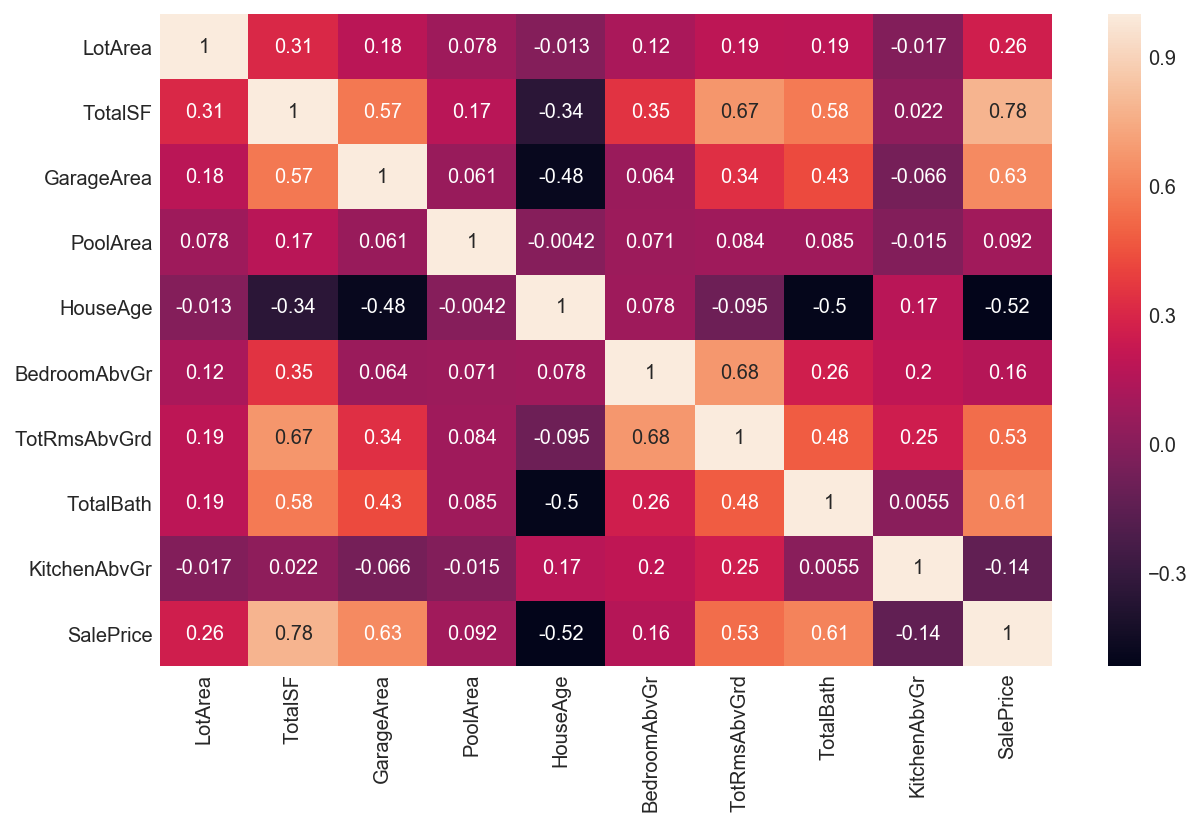

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(house[['LotArea', 'TotalSF', 'GarageArea', 'PoolArea', 'HouseAge',
                     'BedroomAbvGr', 'TotRmsAbvGrd', 'TotalBath', 'KitchenAbvGr','SalePrice']].corr(),
           annot=True)
plt.show()

In [22]:
def vis_scatter(x, y):
    plt.figure(figsize=(6,6))
    plt.scatter(x=x,y=y,data=house)
    plt.title(x + ' vs ' + y)
    plt.xticks(rotation=45)
    plt.show()
    
def vis_box(x, y):
    plt.figure(figsize=(7,7))
    sns.boxplot(x=x,y=y,data=house)
    plt.title(x + ' vs ' + y)
    plt.xticks(rotation=45)
    plt.show()

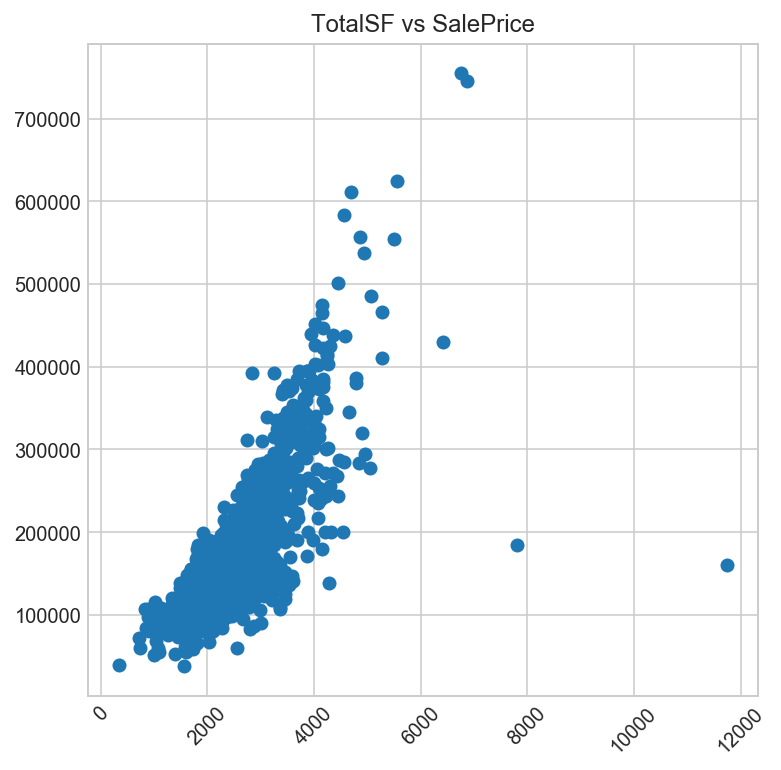

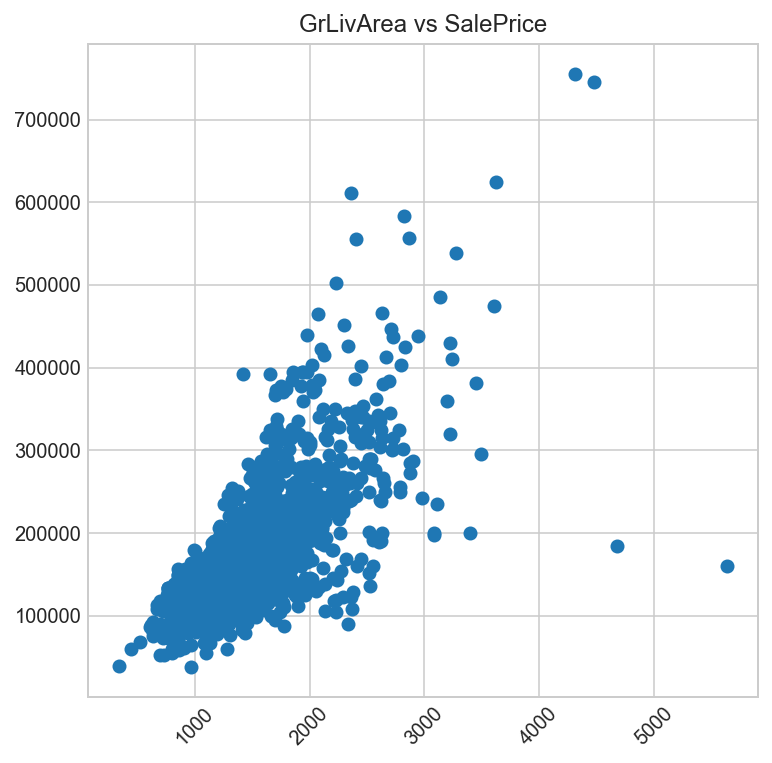

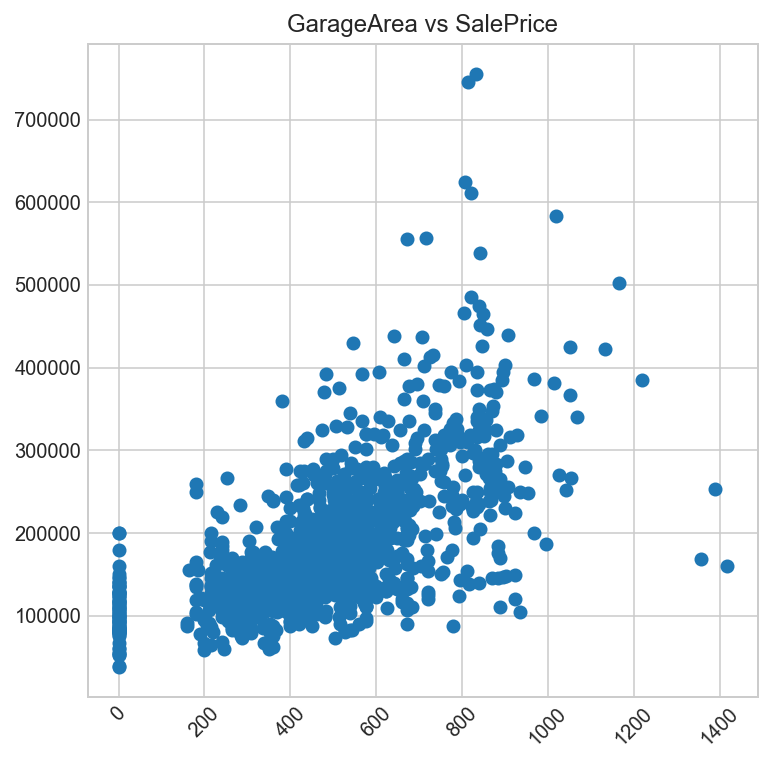

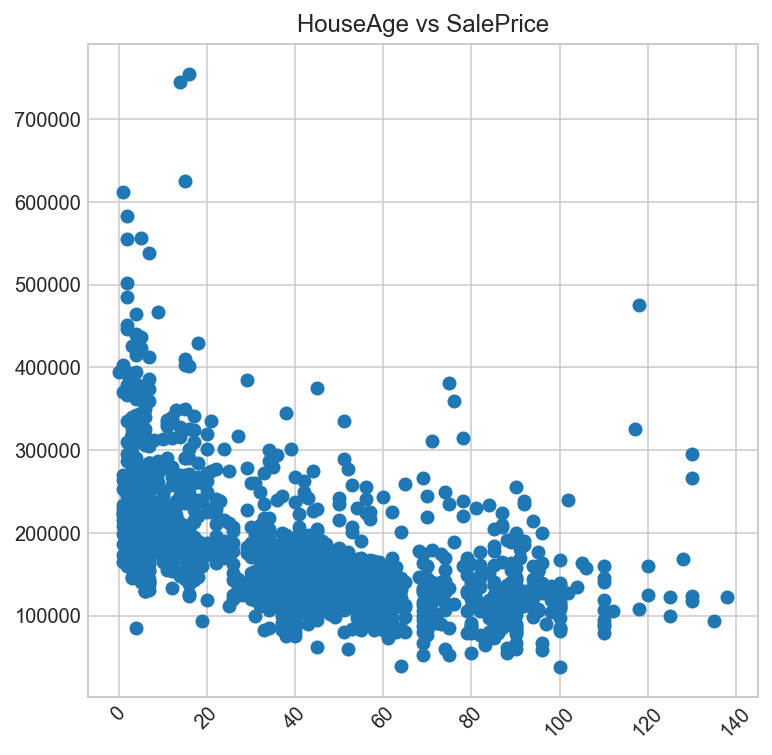

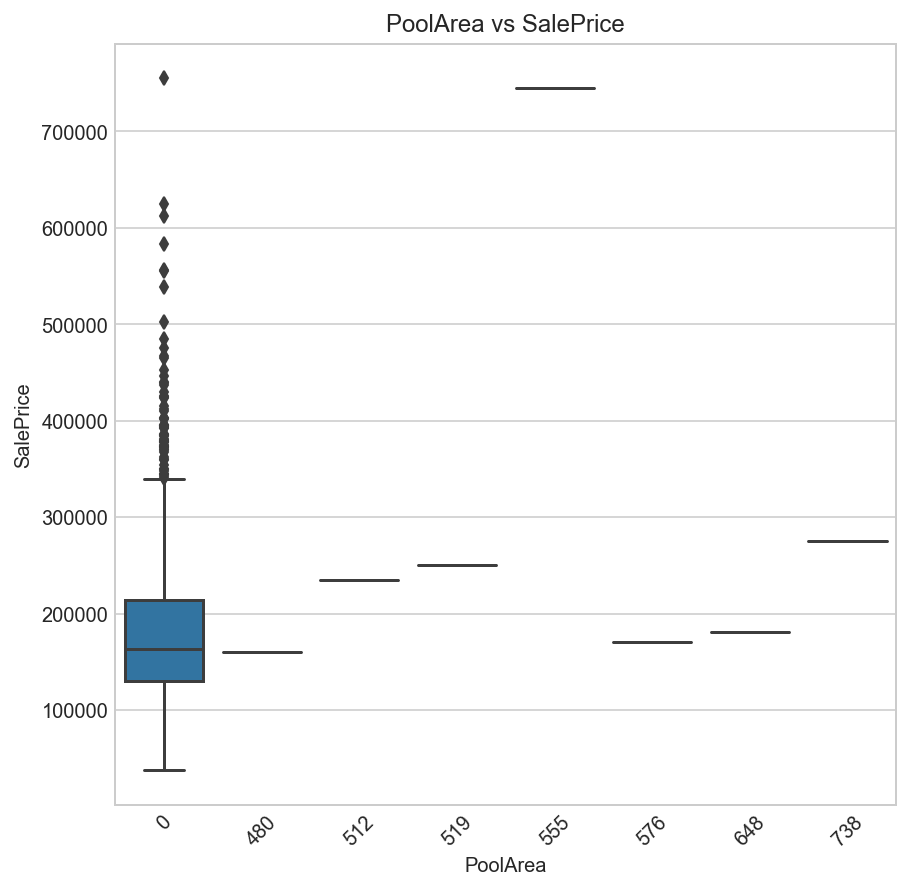

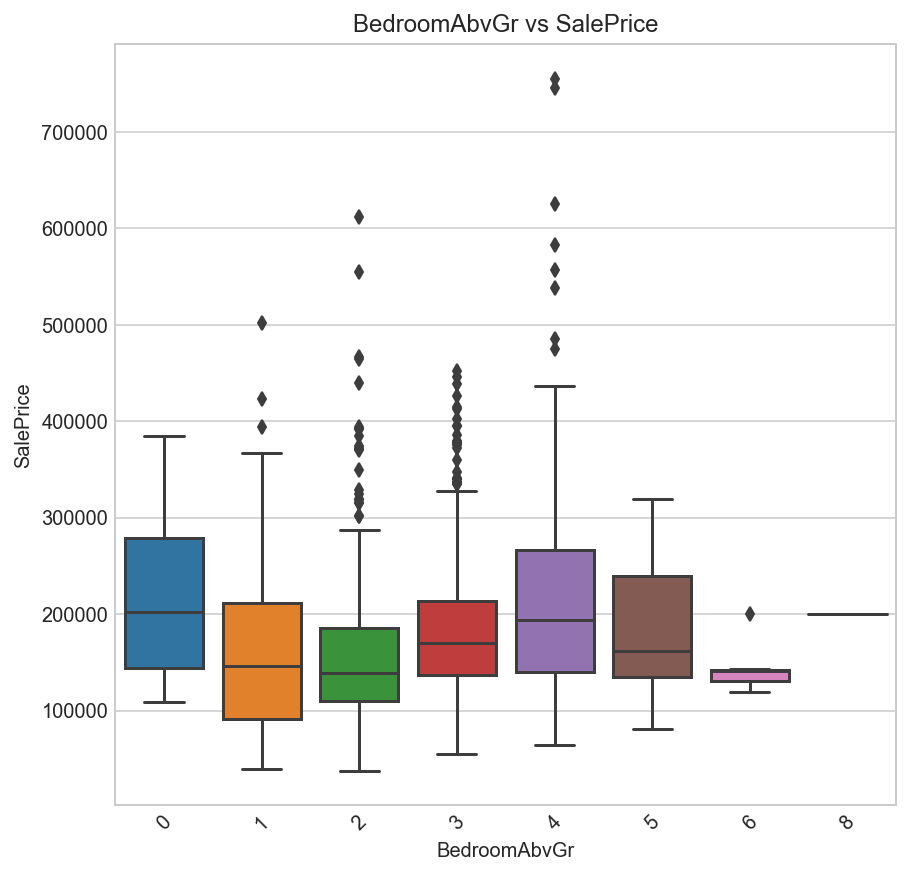

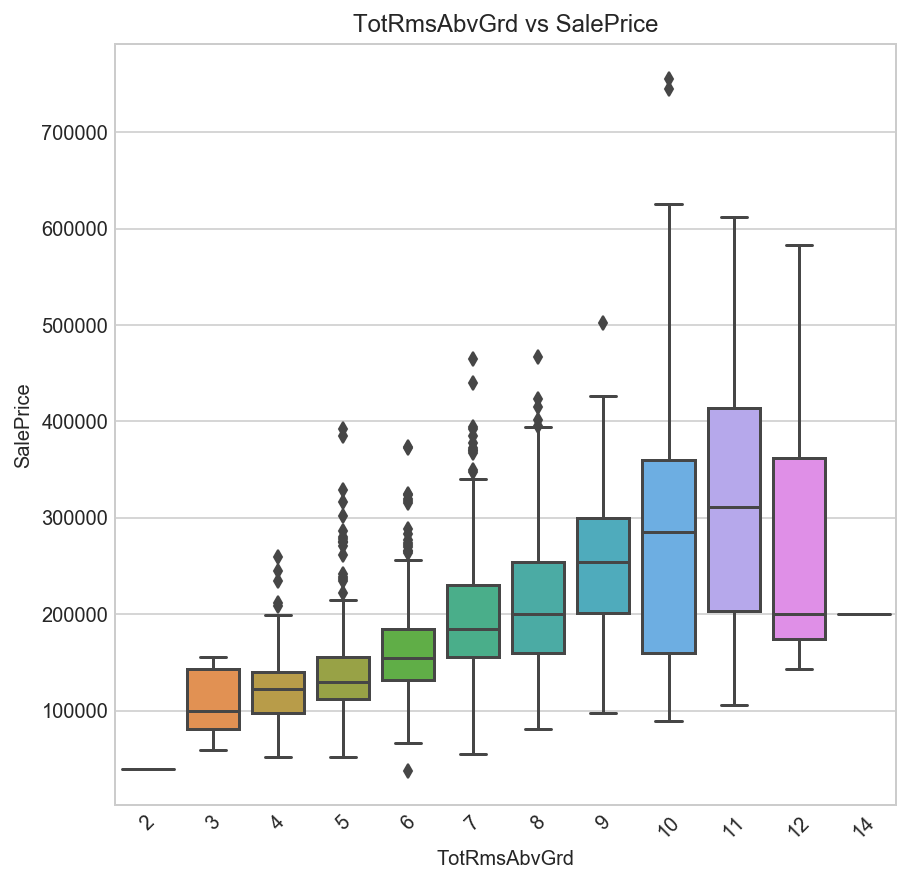

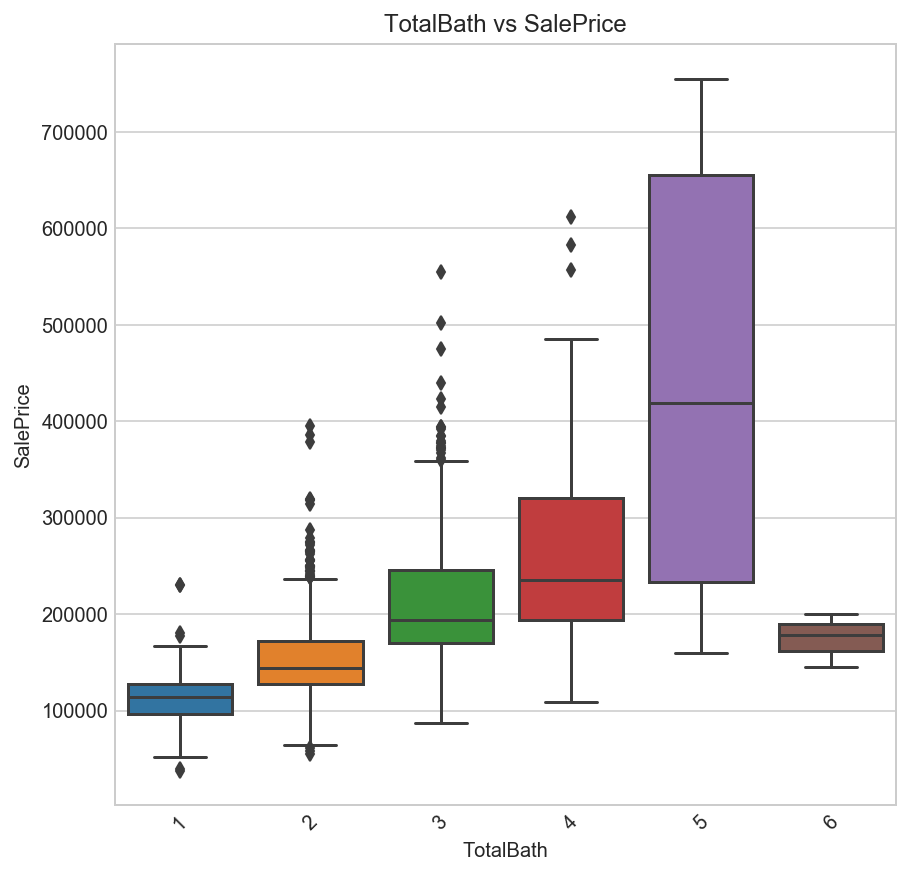

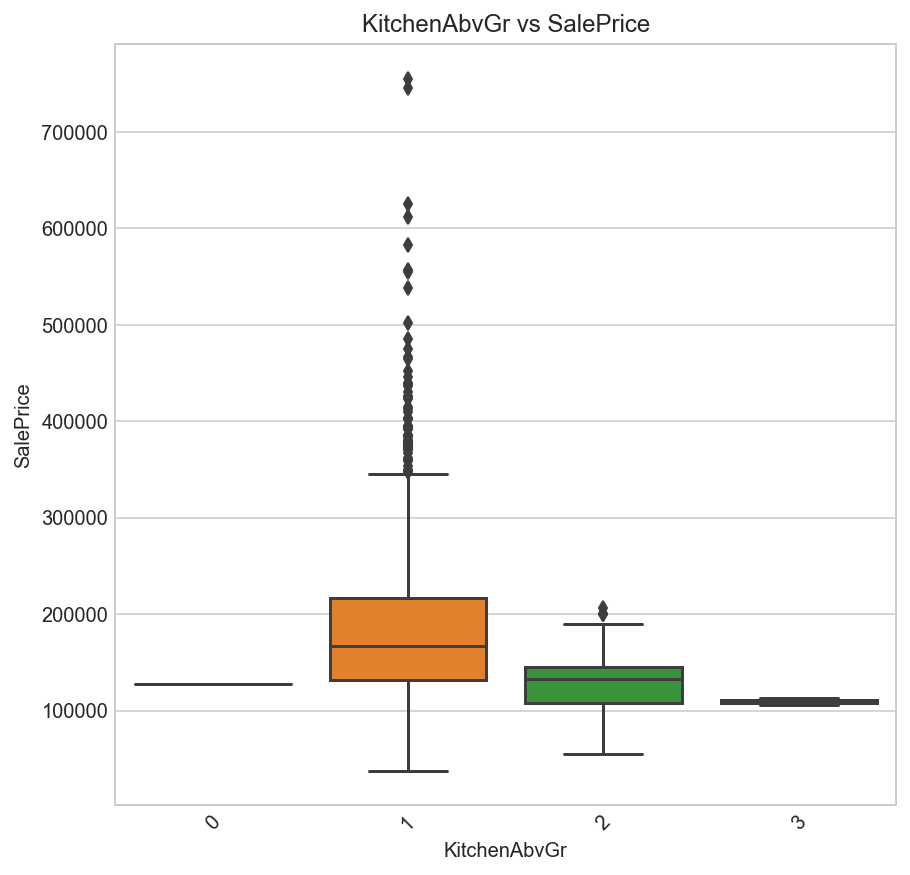

In [23]:
for col in ('TotalSF', 'GrLivArea', 'GarageArea', 'HouseAge'):
    vis_scatter(col,'SalePrice')
    
for col in ('PoolArea', 'BedroomAbvGr', 'TotRmsAbvGrd', 'TotalBath', 'KitchenAbvGr'):
    vis_box(col,'SalePrice')

Indication of outliers: Price < $200k when TotalSF is > 7k. Removing outliers.

In [24]:
house = house.drop(house[(house['SalePrice'] < 200000) & (house['TotalSF'] > 7000)].index)

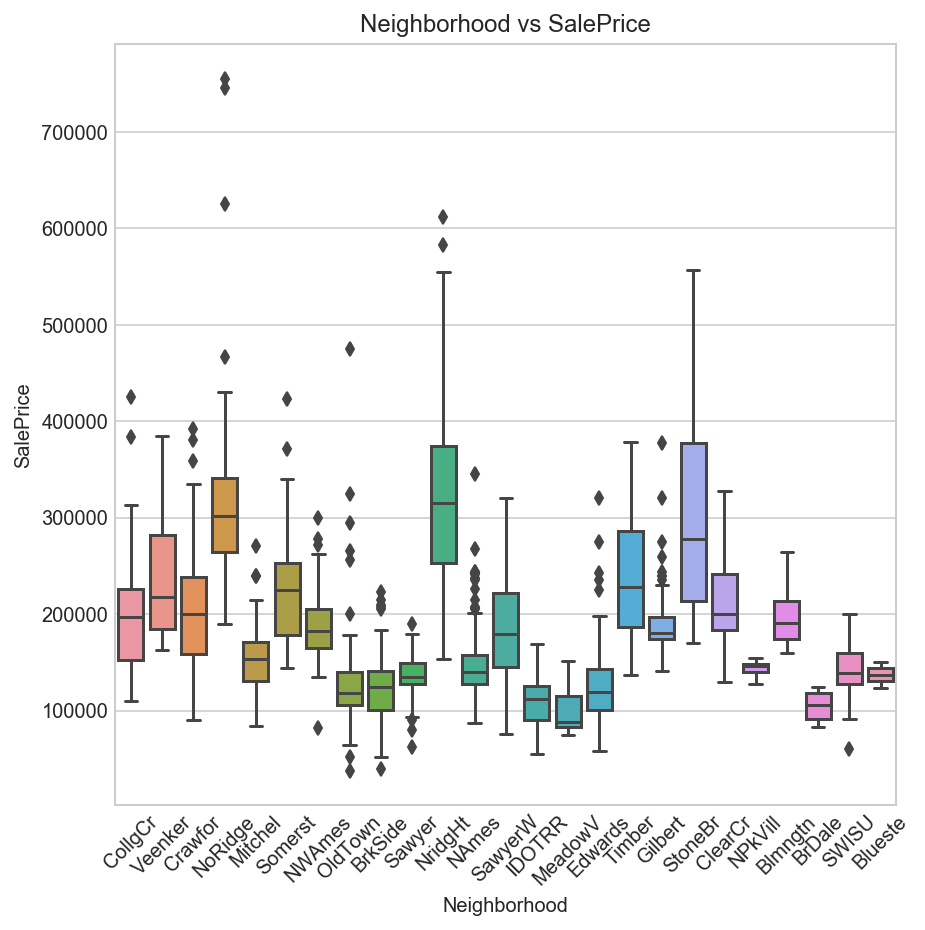

In [25]:
vis_box('Neighborhood','SalePrice')

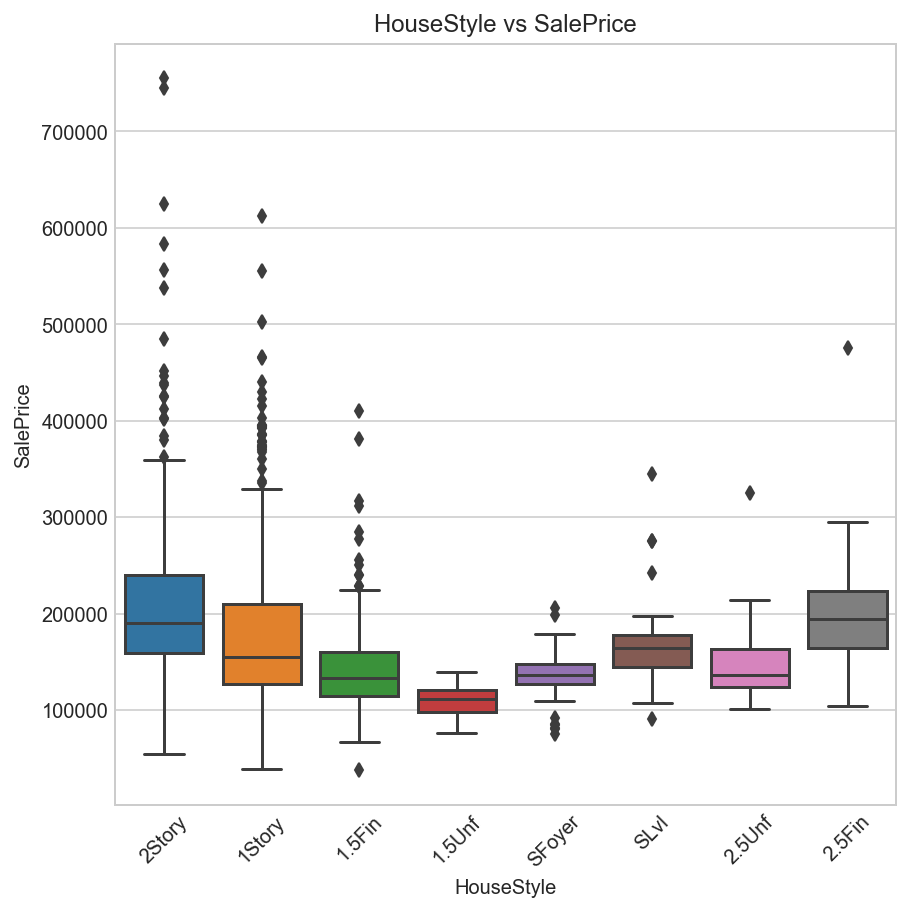

In [26]:
vis_box('HouseStyle','SalePrice')

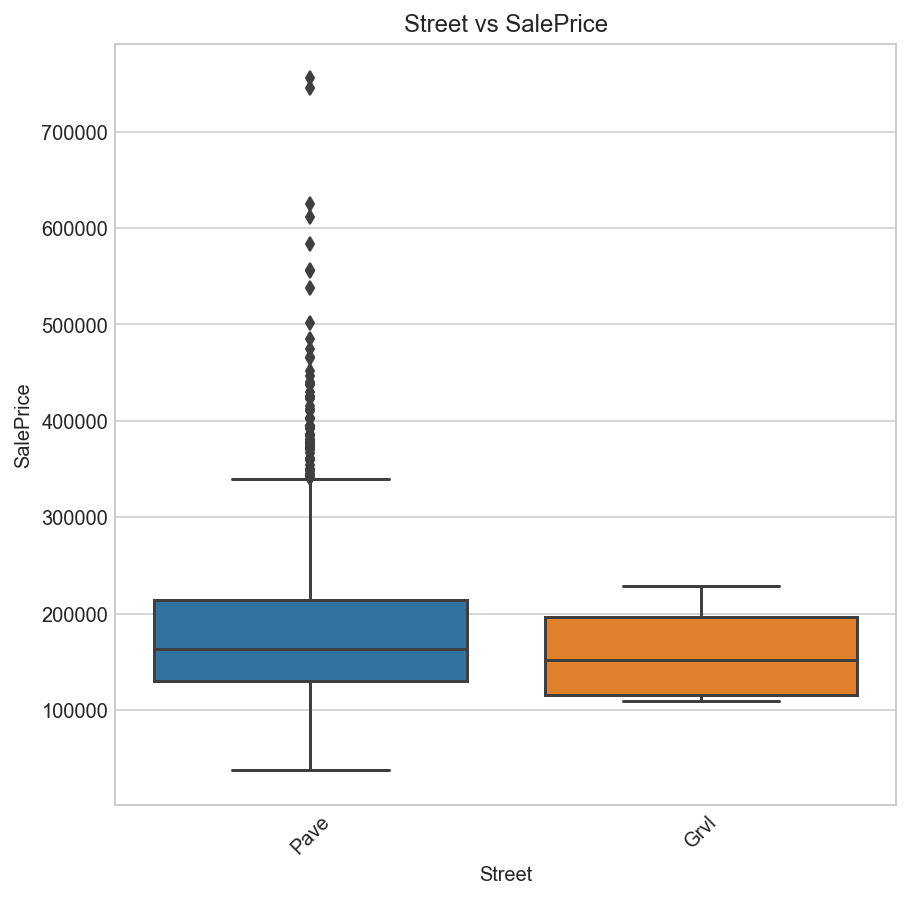

In [27]:
vis_box('Street','SalePrice')

### Fixed Characteristics

- MSSubClass
- Neighborhood
- **Area:** LotArea, TotalSF, GarageArea, PoolArea
- **Rooms:** BedroomAbvGr, TotRmsAbvGrd, TotalBath, KitchenAbvGr
- LotConfig, LotFrontage, LotShape, LandContour, LandSlope
- Condition1, Condition2, HouseStyle, BldgType
- YearBuilt, MoSold, YrSold
- Foundation

In [28]:
house_fixed = house[['MSSubClass', 'Neighborhood', 'LotArea', 'TotalSF', 'GarageArea', 'PoolArea',
                     'BedroomAbvGr', 'TotRmsAbvGrd', 'TotalBath', 'KitchenAbvGr', 'LotConfig', 
                     'LotFrontage', 'LotShape', 'LandContour', 'LandSlope', 'Condition1', 'Condition2', 
                     'HouseStyle', 'BldgType', 'HouseAge', 'MoSold', 'YrSold', 'Foundation','SalePrice']]
house_fixed.head()

,MSSubClass,Neighborhood,LotArea,TotalSF,GarageArea,PoolArea,BedroomAbvGr,TotRmsAbvGrd,TotalBath,KitchenAbvGr,...,LandSlope,Condition1,Condition2,HouseStyle,BldgType,HouseAge,MoSold,YrSold,Foundation,SalePrice
0,60,CollgCr,8450,2566,548,0,3,8,4,1,...,Gtl,Norm,Norm,2Story,1Fam,7,2,2008,PConc,208500
1,20,Veenker,9600,2524,460,0,3,6,3,1,...,Gtl,Feedr,Norm,1Story,1Fam,34,5,2007,CBlock,181500
2,60,CollgCr,11250,2706,608,0,3,6,4,1,...,Gtl,Norm,Norm,2Story,1Fam,9,9,2008,PConc,223500
3,70,Crawfor,9550,2473,642,0,3,7,2,1,...,Gtl,Norm,Norm,2Story,1Fam,95,2,2006,BrkTil,140000
4,60,NoRidge,14260,3343,836,0,4,9,4,1,...,Gtl,Norm,Norm,2Story,1Fam,10,12,2008,PConc,250000


In [29]:
# Unskewing the columns:
from scipy.stats import skew
num_feat = house_fixed.select_dtypes(exclude = 'object').columns
skewed_feat = house_fixed[num_feat].apply(lambda x: skew(x))
skewed_feat = skewed_feat[abs(skewed_feat) > 0.75]
skewed_feat = skewed_feat.index
house_fixed[skewed_feat] = np.log1p(house_fixed[skewed_feat])

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [30]:
housef = pd.get_dummies(house_fixed)

In [31]:
housef.shape

(1448, 120)

### Train Model
Train model on pre-2010 data and test on 2010 data

In [32]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [33]:
X = housef[housef['YrSold_2010'] == 0].drop(columns='SalePrice',axis=1)
y = housef[housef['YrSold_2010'] == 0]['SalePrice']
X_2010 = housef[housef['YrSold_2010'] != 0].drop(columns='SalePrice',axis=1)
y_2010 = housef[housef['YrSold_2010'] != 0]['SalePrice']

In [34]:
ss = StandardScaler()
Xs = ss.fit_transform(X)
Xs_2010 = ss.transform(X_2010)

In [35]:
lm = LinearRegression()
lm.fit(Xs,y)
lm.score(Xs_2010,y_2010)

-1.4452210535332458e+25

In [36]:
cross_val_score(lm,Xs,y,cv=10)
np.mean(cross_val_score(lm,Xs,y,cv=10))

-2.7730430706520793e+25

In [37]:
optimal_lasso = LassoCV(cv=10,verbose=1)
optimal_lasso.fit(Xs,y)

print(optimal_lasso.alpha_)

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0019677715582638853


.......................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


In [38]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.89907062 0.86001873 0.87541466 0.86508281 0.83684373 0.85856894
 0.84922611 0.85644832 0.87031249 0.85160178]
0.8622588197245239


In [39]:
lasso.fit(Xs,y)

Lasso(alpha=0.0019677715582638853, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
1,TotalSF,0.165266,0.165266
9,HouseAge,-0.073783,0.073783
6,TotalBath,0.060531,0.060531
0,LotArea,0.046088,0.046088
2,GarageArea,0.044103,0.044103
41,Neighborhood_NridgHt,0.039635,0.039635
7,KitchenAbvGr,-0.033998,0.033998
5,TotRmsAbvGrd,0.033588,0.033588
31,Neighborhood_Crawfor,0.033583,0.033583
4,BedroomAbvGr,-0.028644,0.028644


In [41]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))

Percent variables zeroed out: 0.35294117647058826


In [42]:
def rmse(model):
    rmse= np.sqrt(-cross_val_score(model, Xs, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [43]:
rmse(lasso).mean()

0.14412242838970624

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [44]:
num_feat = house.select_dtypes(exclude = 'object').columns
skewed_feat = house[num_feat].apply(lambda x: skew(x))
skewed_feat = skewed_feat[abs(skewed_feat) > 0.75]
skewed_feat = skewed_feat.index
house[skewed_feat] = np.log1p(house[skewed_feat])

In [45]:
house = pd.get_dummies(house)

In [49]:
X = house[house['YrSold_2010'] == 0].drop(columns='SalePrice',axis=1)
y = house[house['YrSold_2010'] == 0]['SalePrice']
X_2010 = house[house['YrSold_2010'] != 0].drop(columns='SalePrice',axis=1)
y_2010 = house[house['YrSold_2010'] != 0]['SalePrice']

In [50]:
ss = StandardScaler()
Xs = ss.fit_transform(X)
Xs_2010 = ss.transform(X_2010)

In [51]:
lm = LinearRegression()
lm.fit(Xs,y)
lm.score(Xs_2010,y_2010)

-1.488508469126183e+25

In [52]:
cross_val_score(lm,Xs,y,cv=10)
np.mean(cross_val_score(lm,Xs,y,cv=10))

-2.4317623776021206e+25

In [53]:
optimal_lasso = LassoCV(cv=10,verbose=1)
optimal_lasso.fit(Xs,y)

print(optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0032131044517053637


In [54]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.94063036 0.94846904 0.93858279 0.92766216 0.91038547 0.92737809
 0.89506638 0.9229783  0.94058389 0.90316098]
0.9254897470435018


In [55]:
lasso.fit(Xs,y)

Lasso(alpha=0.0032131044517053637, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [56]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
14,GrLivArea,0.073615,0.073615
32,TotalSF,0.069397,0.069397
2,OverallQual,0.068376,0.068376
3,OverallCond,0.040691,0.040691
1,LotArea,0.038556,0.038556
4,YearBuilt,0.029944,0.029944
23,GarageCars,0.023141,0.023141
34,TotalBath,0.021564,0.021564
7,BsmtFinSF1,0.020224,0.020224
84,Neighborhood_Crawfor,0.018613,0.018613


In [57]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))

Percent variables zeroed out: 0.6744186046511628


In [58]:
rmse(lasso).mean()

0.10543607132911674

I'm sorry, I'm really quite unsure what needs to be done at this point.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [48]:
# A: